In [ ]:
import tensorflow 

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import LabelBinarizer
# from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from keras.layers import Flatten,MaxPooling2D,Dropout

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, load_model

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow-version:", tensorflow.__version__)

import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount("/content/drive/")

Tensorflow-version: 2.8.0
Mounted at /content/drive/


In [ ]:
%tensorflow_version 2.0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))


Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.593376629000005
GPU (s):
0.053377823000005264
GPU speedup over CPU: 67x


# **Accessing the Dataset**

In [ ]:
os.getcwd()
os.chdir("/content/drive/My Drive/Food-11 image dataset/")
target_labels = ["Bread", 
                 "Dairy product", 
                 "Dessert", 
                 "Egg", 
                 "Fried food", 
                 "Meat", 
                 "Noodles-Pasta", 
                 "Rice", 
                 "Seafood", 
                 "Soup", 
                 "Vegetable-Fruit"]
path = "/content/drive/My Drive/Food-11 image dataset/"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.applications import resnet

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=resnet.preprocess_input
        )

validate_datagen = ImageDataGenerator( preprocessing_function = resnet.preprocess_input
                                      )
test_datagen = ImageDataGenerator(
        preprocessing_function=resnet.preprocess_input
    )

In [ ]:
BATCH_SIZE=64

In [ ]:
train_generator = train_datagen.flow_from_directory(path+"training",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validate_generator = validate_datagen.flow_from_directory(path+"validation",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(path+"evaluation",
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes= target_labels,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             seed=42)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


## **ResNet-50**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import AveragePooling2D, Dropout, Dense, Flatten
from keras.models import Model
# from tensorflow.keras.layers import Input


In [ ]:
basemodel=ResNet50(
    weights='imagenet', 
    include_top=False,
    input_shape=(224, 224, 3)
    )


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in basemodel.layers:
	layer.trainable = False

In [ ]:
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(11, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=basemodel.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# **Compile the Model**

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=.01)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import ModelCheckpoint  
filepath="/content/drive/My Drive/Food-11 image dataset/RESNET-50-MODEL{epoch:02d}-{val_accuracy:.2f}.hdf5"

# the ModelCheckpoint mentioned here will save the model after an epoch if the "val-accuracy" has increased. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.01,
    patience = 10,
    restore_best_weights = True,
)

In [ ]:
resnet_history = model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    epochs = 15,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint, earlystopping],
    verbose=1
)

Epoch 1/15
154/154 [==============================] - ETA: 0s - loss: 2.2798 - accuracy: 0.4550 
Epoch 1: val_accuracy improved from -inf to 0.75825, saving model to /content/drive/My Drive/Food-11 image dataset/RESNET-50-MODEL01-0.76.hdf5
154/154 [==============================] - 3539s 23s/step - loss: 2.2798 - accuracy: 0.4550 - val_loss: 0.8420 - val_accuracy: 0.7583
Epoch 2/15
154/154 [==============================] - ETA: 0s - loss: 1.2968 - accuracy: 0.5433
Epoch 2: val_accuracy did not improve from 0.75825
154/154 [==============================] - 237s 2s/step - loss: 1.2968 - accuracy: 0.5433 - val_loss: 0.7673 - val_accuracy: 0.7553
Epoch 3/15
154/154 [==============================] - ETA: 0s - loss: 1.1929 - accuracy: 0.5912
Epoch 3: val_accuracy improved from 0.75825 to 0.77948, saving model to /content/drive/My Drive/Food-11 image dataset/RESNET-50-MODEL03-0.78.hdf5
154/154 [==============================] - 232s 2s/step - loss: 1.1929 - accuracy: 0.5912 - val_loss: 0.7

In [ ]:
# converting the epochs history to data frame and saving in drive
resnet_history_frame = pd.DataFrame(resnet_history.history)

In [ ]:
resnet_history_frame.to_csv("resnet_history.csv")
!cp resnet_history.csv path

In [ ]:
# retrieving the saved file
resnet_history_frame = pd.read_csv("resnet_history.csv")
resnet_history_frame.index  = np.arange(1,16) 
resnet_history_frame.head(2)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
1,0,2.279782,0.455009,0.841996,0.758255
2,1,1.296788,0.543256,0.767312,0.755307


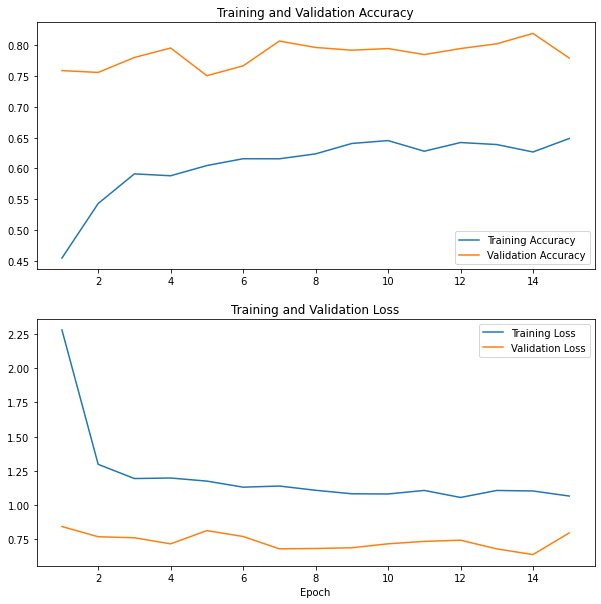

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(resnet_history_frame['accuracy'], label='Training Accuracy')
plt.plot(resnet_history_frame['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(resnet_history_frame['loss'], label='Training Loss')
plt.plot(resnet_history_frame['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# **Fine-Tuning**

In [ ]:
for i,layer in enumerate(basemodel.layers):
    print(i,layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
for layer in basemodel.layers[:-31]:
    layer.trainable = False

for layer in basemodel.layers[-31:]:
    layer.trainable = True

In [ ]:
for layer in basemodel.layers:
	print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7f8b73b8cc10>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f8b70219a50>: False
<keras.layers.convolutional.Conv2D object at 0x7f8b70178410>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8a8f20d0d0>: False
<keras.layers.core.activation.Activation object at 0x7f8a8db058d0>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f8a8db64810>: False
<keras.layers.pooling.MaxPooling2D object at 0x7f8a8f1b8210>: False
<keras.layers.convolutional.Conv2D object at 0x7f8a8db49590>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8b70167a90>: False
<keras.layers.core.activation.Activation object at 0x7f8b701784d0>: False
<keras.layers.convolutional.Conv2D object at 0x7f8a8f143910>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8a8f03f350>: False
<keras.layers.core.activation.Activation object at 0x7f8a8f0

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=1e-4)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.01,
    patience = 10,
    restore_best_weights = True,
)

In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

filepath_ft="/content/drive/My Drive/Food-11 image dataset/RESNET50-FT-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint_ft = ModelCheckpoint(filepath_ft, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_ft = [checkpoint_ft]

In [ ]:
# fine tune the already trained model
resnet50_ft_history = model.fit(
    train_generator, 
    batch_size=64,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    epochs = 15,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint_ft, earlystopping, anne],
    verbose=1
)

Epoch 1/15
154/154 [==============================] - ETA: 0s - loss: 1.2031 - accuracy: 0.6200
Epoch 1: val_accuracy improved from -inf to 0.78037, saving model to /content/drive/My Drive/Food-11 image dataset/RESNET50-FT-01-0.78.hdf5
154/154 [==============================] - 278s 2s/step - loss: 1.2031 - accuracy: 0.6200 - val_loss: 0.9762 - val_accuracy: 0.7804 - lr: 1.0000e-04
Epoch 2/15
154/154 [==============================] - ETA: 0s - loss: 1.0007 - accuracy: 0.6801
Epoch 2: val_accuracy improved from 0.78037 to 0.80071, saving model to /content/drive/My Drive/Food-11 image dataset/RESNET50-FT-02-0.80.hdf5
154/154 [==============================] - 274s 2s/step - loss: 1.0007 - accuracy: 0.6801 - val_loss: 0.8032 - val_accuracy: 0.8007 - lr: 1.0000e-04
Epoch 3/15
154/154 [==============================] - ETA: 0s - loss: 0.8655 - accuracy: 0.7225
Epoch 3: val_accuracy did not improve from 0.80071
154/154 [==============================] - 268s 2s/step - loss: 0.8655 - accurac

In [ ]:
resnet50_ft_history_frame = pd.DataFrame(resnet50_ft_history.history)

In [ ]:
resnet50_ft_history_frame.to_csv("resnet50_ft_history_frame.csv")
!cp resnet50_ft_history_frame.csv path

In [ ]:
resnet50ft_history_frame = pd.read_csv("resnet50_ft_history_frame.csv")
resnet50_ft_history_frame.index = np.arange(1,16)
resnet50_ft_history_frame.head(2)
#12,32

,loss,accuracy,val_loss,val_accuracy,lr
1,1.203089,0.619976,0.976187,0.780366,0.0001
2,1.000732,0.680065,0.803225,0.800708,0.0001


In [ ]:
resnet50_full_history = pd.concat([resnet50_ft_history_frame], axis=0)

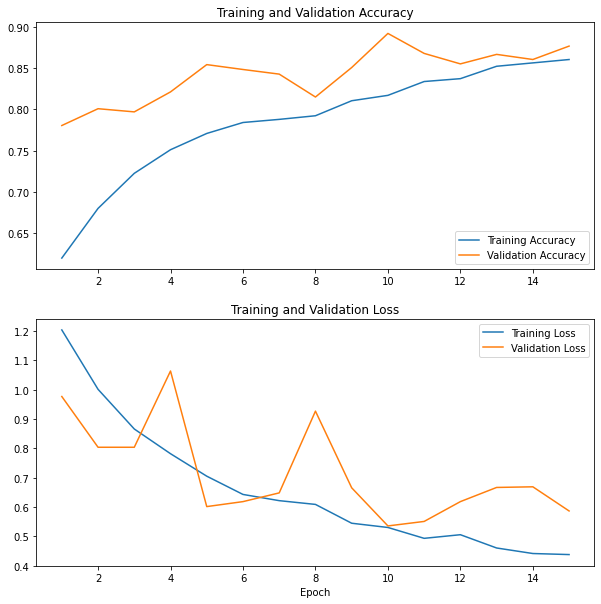

In [ ]:
acc = resnet50_full_history["accuracy"]
val_acc = resnet50_full_history['val_accuracy']

loss = resnet50_full_history['loss']
val_loss = resnet50_full_history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# **Evaluation of Model using Test Generator**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# a function to evaluate the prediction of dataset from a given model
def model_evaluation(model, generator):
  generator.reset() # There is a reset() method for the datagenerators which resets it to the first batch. So whenever you would want to correlate the model output with the filenames you need to set shuffle as False and reset the datagenerator before performing any prediction. This will ensure that our files are being read properly and there is nothing wrong with them.

  true_classes = generator.classes
  class_indices = dict((v,k) for k,v in generator.class_indices.items())
  preds = model.predict(generator)
  preds_classes = np.argmax(preds, axis=1)
  return [true_classes, preds_classes, generator.class_indices.keys()]

In [ ]:
# for the prediction made, this function prints a confusion matrix 
def plot_confusion_matrix(true_classes, preds_classes, target_names):
  cm = confusion_matrix(true_classes, preds_classes)

  df_cm = pd.DataFrame(cm, columns=target_names, index = target_names)
  plt.figure(figsize=(12,12))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, annot=True, fmt='g', cbar=False, cmap="rocket_r") # font size , annot_kws={"size": 16}
  plt.title('Confusion Matrix\n', y=1.1)
  plt.ylabel('Actual Label\n')
  plt.xlabel('Predicted Label\n')

  plt.show()

In [ ]:
result = model_evaluation(model, test_generator)
true_classes, preds_classes, target_names = result[0], result[1], result[2]
test_ft_acc=accuracy_score(true_classes, preds_classes) 
print("ResNet-50 WITH Fine-Tuning on Testing Set has Accuracy: {:.2f}%".format(test_ft_acc * 100))

ResNet-50 WITH Fine-Tuning on Testing Set has Accuracy: 90.98%


In [ ]:
print(classification_report(true_classes, preds_classes,target_names =  target_names))

                 precision    recall  f1-score   support

          Bread       0.92      0.85      0.88       368
  Dairy product       0.91      0.85      0.88       148
        Dessert       0.90      0.83      0.87       500
            Egg       0.95      0.88      0.91       335
     Fried food       0.87      0.92      0.90       287
           Meat       0.86      0.95      0.90       432
  Noodles-Pasta       0.97      0.99      0.98       147
           Rice       0.98      0.93      0.95        96
        Seafood       0.93      0.90      0.91       303
           Soup       0.96      0.97      0.96       500
Vegetable-Fruit       0.82      1.00      0.90       231

       accuracy                           0.91      3347
      macro avg       0.92      0.91      0.91      3347
   weighted avg       0.91      0.91      0.91      3347



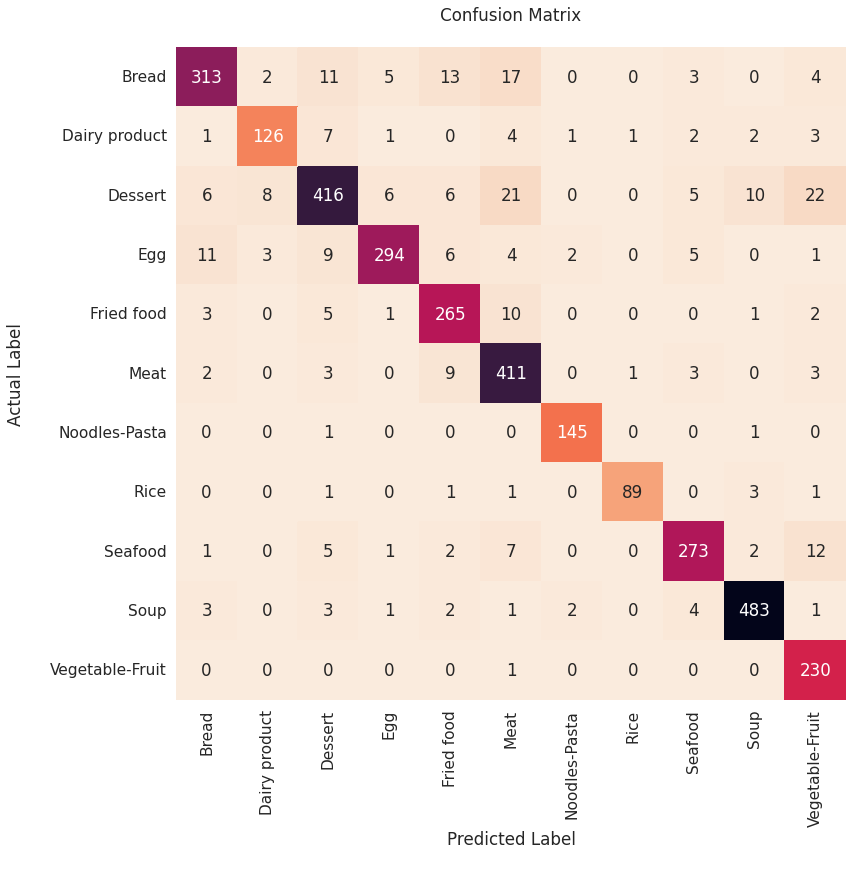

In [ ]:
plot_confusion_matrix(true_classes, preds_classes, target_names)